## catboost, lightgbm, xgboost, autugluon

In [4]:
rand_seed = 13

In [5]:
import pandas as pd
data = pd.read_csv("pre_train.csv").drop(["Name","New_Price2"],axis=1)
data = data[data['Kilometers_Driven'] <= 1000000].reset_index(drop=True)

In [13]:
data

,Location,Year,Kilometers_Driven,Fuel_Type,Seats,Price,brand,Engine_CC,Power_bhp,Mileage_kmpl,Transauto1,Owner_Type2
0,Mumbai,2010,72000,CNG,5.0,1.75,Maruti,998.0,58.16,26.60,0,1
1,Pune,2015,41000,Diesel,5.0,12.50,Hyundai,1582.0,126.20,19.67,0,1
2,Chennai,2011,46000,Petrol,5.0,4.50,Honda,1199.0,88.70,18.20,0,1
3,Chennai,2012,87000,Diesel,7.0,6.00,Maruti,1248.0,88.76,20.77,0,1
4,Coimbatore,2013,40670,Diesel,5.0,17.74,Audi,1968.0,140.80,15.20,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
6013,Delhi,2014,27365,Diesel,5.0,4.75,Maruti,1248.0,74.00,28.40,0,1
6014,Jaipur,2015,100000,Diesel,5.0,4.00,Hyundai,1120.0,71.00,24.40,0,1
6015,Jaipur,2012,55000,Diesel,8.0,2.90,Mahindra,2498.0,112.00,14.00,0,2
6016,Kolkata,2013,46000,Petrol,5.0,2.65,Maruti,998.0,67.10,18.90,0,1


In [6]:
df = data.copy()
X = df.drop(columns=['Price'])
y = df['Price']

In [7]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

# 데이터 불러오기 (예: Pandas DataFrame)
df = data.copy()
X = df.drop(columns=['Price'])
y = df['Price']

# 예제 데이터를 생성하여 사용합니다.
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

# CatBoost 회귀 모델 초기화
model = CatBoostRegressor(iterations=100, # 반복 횟수
                          learning_rate=0.1, # 학습률
                          depth=6) # 트리 깊이 등의 하이퍼파라미터 설정

# # CatBoost 회귀 모델 정의 및 학습
# model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6)
# model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

# 명목형 변수의 인덱스 추출
cat_features = ['Location','brand','Fuel_Type']

# CatBoost 모델 학습을 위해 Pool 객체 생성
train_pool = Pool(X_train, y_train, cat_features=cat_features)

# 모델 학습
model.fit(train_pool,early_stopping_rounds=50, verbose=100)
test_pool = Pool(X_test, cat_features=cat_features)
predictions1 = model.predict(test_pool)

# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, predictions1,squared=False)
print(f"Mean Squared Error: {rmse}")


0:	learn: 10.1300280	total: 63.1ms	remaining: 6.25s
99:	learn: 2.4429654	total: 208ms	remaining: 0us
Mean Squared Error: 4.391549289178623


In [5]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split

df = data.copy()
X = df.drop(columns=['Price'])
y = df['Price']
# 명목형 변수를 숫자형으로 변환
X['Location'] = df['Location'].astype('category')
X['brand'] = df['brand'].astype('category')
X['Fuel_Type'] = df['Fuel_Type'].astype('category')


# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_seed)
# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=['Location','brand','Fuel_Type'])
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=['Location','brand','Fuel_Type'])

# LightGBM 모델 학습
params = {
    'objective': 'regression',
    'metric': 'rmse'
}

model = lgb.train(params, train_data, valid_sets=[val_data])
predictions2 = model.predict(X_test)
# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, predictions2,squared=False)
print(f"Mean Squared Error: {rmse}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 3851, number of used features: 11
[LightGBM] [Info] Start training from score 9.462062
[1]	valid_0's rmse: 10.126
[2]	valid_0's rmse: 9.35679
[3]	valid_0's rmse: 8.68787
[4]	valid_0's rmse: 8.09241
[5]	valid_0's rmse: 7.60474
[6]	valid_0's rmse: 7.1145
[7]	valid_0's rmse: 6.69451
[8]	valid_0's rmse: 6.31436
[9]	valid_0's rmse: 5.99071
[10]	valid_0's rmse: 5.68426
[11]	valid_0's rmse: 5.43253
[12]	valid_0's rmse: 5.20536
[13]	valid_0's rmse: 5.00977
[14]	valid_0's rmse: 4.81962
[15]	valid_0's rmse: 4.65499
[16]	valid_0's rmse: 4.51375
[17]	valid_0's rmse: 4.3894
[18]	valid_0's rmse: 4.25996
[19]	valid_0's rmse: 4.17324
[20]	valid_0's rmse: 4.06953
[21]	valid_0's rmse: 3.98

/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [22]:
model.feature_names_

['Location',
 'Year',
 'Kilometers_Driven',
 'Fuel_Type',
 'Seats',
 'brand',
 'Engine_CC',
 'Power_bhp',
 'Mileage_kmpl',
 'Transauto1',
 'Owner_Type2']

In [23]:
model.feature_importances_

array([ 1.03548791, 22.17662743,  4.64748934,  2.08515805,  0.99750042,
        8.75441453, 10.01149353, 43.46079848,  3.69206042,  3.0703269 ,
        0.068643  ])

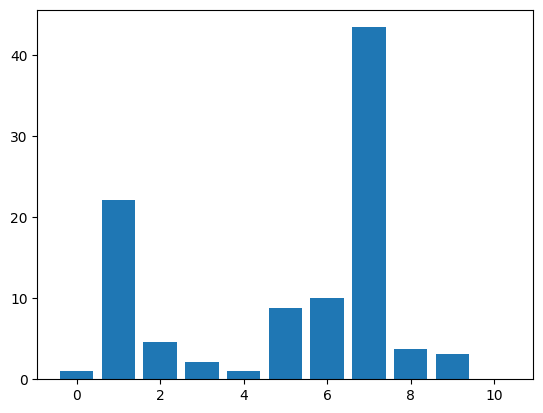

In [20]:
import matplotlib.pyplot as plt
model.feature_importances_
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

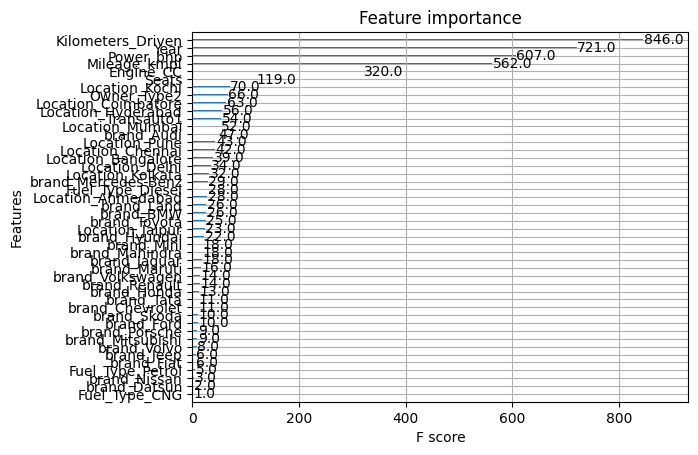

In [21]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(bst)
plt.show()

In [17]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# 데이터 불러오기
df = data.copy()
# 명목형 변수 추출
categorical_cols = ['Location', 'brand', 'Fuel_Type']

# 명목형 변수 One-Hot-Encoding
encoder = OneHotEncoder(sparse=False)
encoded_cols = encoder.fit_transform(df[categorical_cols])

# One-Hot-Encoding된 데이터프레임 생성
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

# 기존 데이터에서 명목형 변수 제거하고 One-Hot-Encoding된 변수 추가
df = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

# 설명변수와 타겟변수 분리
X = df.drop('Price', axis=1)
y = df['Price']

# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_seed)
# XGBoost 모델 학습
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

num_round = 100
bst = xgb.train(params, dtrain, num_round, [(dval, 'test'), (dtrain, 'train')])

# 예측
predictions3 = bst.predict(dtest)
# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, predictions3,squared=False)
print(f"Mean Squared Error: {rmse}")

[0]	test-rmse:10.88373	train-rmse:10.39208
[1]	test-rmse:8.66767	train-rmse:7.77270
[2]	test-rmse:7.24176	train-rmse:5.95103
[3]	test-rmse:6.17545	train-rmse:4.67599
[4]	test-rmse:5.70825	train-rmse:3.79727
[5]	test-rmse:5.30543	train-rmse:3.21205
[6]	test-rmse:5.06488	train-rmse:2.80589
[7]	test-rmse:4.89962	train-rmse:2.54514
[8]	test-rmse:4.79737	train-rmse:2.34949
[9]	test-rmse:4.77830	train-rmse:2.20622
[10]	test-rmse:4.67838	train-rmse:2.07443
[11]	test-rmse:4.61770	train-rmse:1.96064
[12]	test-rmse:4.57904	train-rmse:1.88466
[13]	test-rmse:4.56841	train-rmse:1.83985
[14]	test-rmse:4.54693	train-rmse:1.79154
[15]	test-rmse:4.53589	train-rmse:1.75809
[16]	test-rmse:4.49919	train-rmse:1.73440
[17]	test-rmse:4.48048	train-rmse:1.64971
[18]	test-rmse:4.45066	train-rmse:1.62141
[19]	test-rmse:4.44080	train-rmse:1.59950
[20]	test-rmse:4.44560	train-rmse:1.55590
[21]	test-rmse:4.42116	train-rmse:1.53412
[22]	test-rmse:4.39840	train-rmse:1.49144
[23]	test-rmse:4.35375	train-rmse:1.43871


/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[38]	test-rmse:4.24491	train-rmse:1.14306
[39]	test-rmse:4.21552	train-rmse:1.12012
[40]	test-rmse:4.20777	train-rmse:1.10093
[41]	test-rmse:4.20083	train-rmse:1.08511
[42]	test-rmse:4.19549	train-rmse:1.06992
[43]	test-rmse:4.19499	train-rmse:1.06385
[44]	test-rmse:4.19110	train-rmse:1.04817
[45]	test-rmse:4.19240	train-rmse:1.04344
[46]	test-rmse:4.19546	train-rmse:1.02847
[47]	test-rmse:4.19232	train-rmse:1.01927
[48]	test-rmse:4.18658	train-rmse:1.00446
[49]	test-rmse:4.18221	train-rmse:0.99386
[50]	test-rmse:4.18004	train-rmse:0.99015
[51]	test-rmse:4.18340	train-rmse:0.98103
[52]	test-rmse:4.17342	train-rmse:0.96311
[53]	test-rmse:4.17287	train-rmse:0.95123
[54]	test-rmse:4.17059	train-rmse:0.93028
[55]	test-rmse:4.16834	train-rmse:0.92182
[56]	test-rmse:4.16980	train-rmse:0.90707
[57]	test-rmse:4.16938	train-rmse:0.90082
[58]	test-rmse:4.16326	train-rmse:0.88784
[59]	test-rmse:4.15961	train-rmse:0.87274
[60]	test-rmse:4.15824	train-rmse:0.85864
[61]	test-rmse:4.15774	train-rmse:

In [7]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, (predictions1+predictions2+predictions3)/3,squared=False)
print(f"Mean Squared Error: {rmse}")

Mean Squared Error: 4.249520787751862


In [24]:
import pandas as pd
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_squared_error
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
from sklearn.model_selection import train_test_split

df = data.copy()
# 설명변수와 타겟변수 분리
X = df.drop('Price', axis=1)
y = df['Price']

# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

train_data = TabularDataset(pd.concat([X_train, y_train], axis=1))
test_data = TabularDataset(pd.concat([X_test, y_test], axis=1))

# Autogluon 모델 학습
predictor = TabularPredictor(label='Price').fit(train_data)

# 테스트 데이터로 예측 수행
y_pred = predictor.predict(test_data.drop(columns=['Price']))

# 성능 측정 (평균 제곱 오차 사용)
rmse = mean_squared_error(test_data['Price'], y_pred, squared = False)
print(f"Mean Squared Error: {rmse}")


No path specified. Models will be saved in: "AutogluonModels/ag-20231130_054304"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231130_054304"
AutoGluon Version:  0.8.3b20231113
Python Version:     3.8.18
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #98~20.04.1-Ubuntu SMP Mon Oct 9 16:43:45 UTC 2023
Disk Space Avail:   1492.13 GB / 1967.85 GB (75.8%)
Train Data Rows:    4814
Train Data Columns: 11
Label Column: Price
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (120.0, 0.44, 9.42122, 10.95531)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFea

[1000]	valid_set's rmse: 3.54718


	-3.538	 = Validation score   (-root_mean_squared_error)
	3.59s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.2522	 = Validation score   (-root_mean_squared_error)
	0.33s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 80.83s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231130_054304")


Mean Squared Error: 4.131704677273626


In [28]:
feature_importance = predictor.feature_importance(train_data)
print(feature_importance)

Computing feature importance via permutation shuffling for 11 features using 4814 rows with 5 shuffle sets...
	26.98s	= Expected runtime (5.4s per shuffle set)
	18.81s	= Actual runtime (Completed 5 of 5 shuffle sets)


                   importance    stddev       p_value  n  p99_high   p99_low
Power_bhp            5.264046  0.111814  2.441289e-08  5  5.494271  5.033820
Year                 4.686480  0.116634  4.599731e-08  5  4.926631  4.446330
brand                3.324075  0.056885  1.028804e-08  5  3.441203  3.206947
Engine_CC            2.175891  0.053352  4.333891e-08  5  2.285743  2.066039
Kilometers_Driven    1.408424  0.057618  3.353681e-07  5  1.527061  1.289787
Mileage_kmpl         1.237816  0.035787  8.375212e-08  5  1.311503  1.164129
Location             0.873084  0.042114  6.475966e-07  5  0.959797  0.786372
Transauto1           0.862017  0.049851  1.336204e-06  5  0.964661  0.759374
Fuel_Type            0.675086  0.033436  7.197206e-07  5  0.743930  0.606241
Seats                0.244253  0.013810  1.221016e-06  5  0.272687  0.215818
Owner_Type2          0.057955  0.006124  1.473711e-05  5  0.070563  0.045346


## Except some variables

In [9]:
import pandas as pd
data = pd.read_csv("pre_train.csv").drop(["Name","New_Price2","brand","Seats","Transauto1","Fuel_Type"],axis=1)
cat_features = ['Location']

In [10]:
from catboost import CatBoostRegressor, Pool

# 데이터 불러오기 (예: Pandas DataFrame)
df = data.copy()
X = df.drop(columns=['Price'])
y = df['Price']

# 예제 데이터를 생성하여 사용합니다.
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

# CatBoost 회귀 모델 초기화
model = CatBoostRegressor(iterations=100, # 반복 횟수
                          learning_rate=0.1, # 학습률
                          depth=6) # 트리 깊이 등의 하이퍼파라미터 설정

# # CatBoost 회귀 모델 정의 및 학습
# model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6)
# model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

# 명목형 변수의 인덱스 추출
cat_features = cat_features

# CatBoost 모델 학습을 위해 Pool 객체 생성
train_pool = Pool(X_train, y_train, cat_features=cat_features)

# 모델 학습
model.fit(train_pool,early_stopping_rounds=50, verbose=100)
test_pool = Pool(X_test, cat_features=cat_features)
predictions1 = model.predict(test_pool)

# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, predictions1,squared=False)
print(f"Mean Squared Error: {rmse}")


0:	learn: 10.4111693	total: 3.35ms	remaining: 331ms
99:	learn: 3.2434317	total: 140ms	remaining: 0us
Mean Squared Error: 4.264617176873511


In [11]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split

df = data.copy()
X = df.drop(columns=['Price'])
y = df['Price']
# 명목형 변수를 숫자형으로 변환
for i in range(len(cat_features)):
    X[cat_features[i]] = df[cat_features[i]].astype('category')


# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_seed)

# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_features)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features)

# LightGBM 모델 학습
params = {
    'objective': 'regression',
    'metric': 'rmse'
}

model = lgb.train(params, train_data, valid_sets=[val_data])
predictions2 = model.predict(X_test)
# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, predictions2,squared=False)
print(f"Mean Squared Error: {rmse}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 3852, number of used features: 7
[LightGBM] [Info] Start training from score 9.481986
[1]	valid_0's rmse: 10.465
[2]	valid_0's rmse: 9.65313
[3]	valid_0's rmse: 8.92816
[4]	valid_0's rmse: 8.27894
[5]	valid_0's rmse: 7.70665
[6]	valid_0's rmse: 7.2155
[7]	valid_0's rmse: 6.80185
[8]	valid_0's rmse: 6.44657
[9]	valid_0's rmse: 6.1306
[10]	valid_0's rmse: 5.87771
[11]	valid_0's rmse: 5.65598
[12]	valid_0's rmse: 5.45455
[13]	valid_0's rmse: 5.30931
[14]	valid_0's rmse: 5.1634
[15]	valid_0's rmse: 5.01941
[16]	valid_0's rmse: 4.88919
[17]	valid_0's rmse: 4.79496
[18]	valid_0's rmse: 4.69359
[19]	valid_0's rmse: 4.59198
[20]	valid_0's rmse: 4.52875
[21]	valid_0's rmse: 4.46081
[22]	valid_0's rmse: 4.4141
[23]	valid_0's rmse: 4.37065
[24]	

/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [12]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# 데이터 불러오기
df = data.copy()
# 명목형 변수 추출
categorical_cols = cat_features

# 명목형 변수 One-Hot-Encoding
encoder = OneHotEncoder(sparse=False)
encoded_cols = encoder.fit_transform(df[categorical_cols])

# One-Hot-Encoding된 데이터프레임 생성
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

# 기존 데이터에서 명목형 변수 제거하고 One-Hot-Encoding된 변수 추가
df = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

# 설명변수와 타겟변수 분리
X = df.drop('Price', axis=1)
y = df['Price']

# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_seed)

# XGBoost 모델 학습
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
dval = xgb.DMatrix(X_val, label=y_val)

num_round = 100
bst = xgb.train(params, dtrain, num_round, [(dval, 'test'), (dtrain, 'train')])

# 예측
predictions3 = bst.predict(dtest)
# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, predictions3,squared=False)
print(f"Mean Squared Error: {rmse}")

[0]	test-rmse:10.97297	train-rmse:10.59461
[1]	test-rmse:8.38734	train-rmse:7.98357
[2]	test-rmse:6.64916	train-rmse:6.17986
[3]	test-rmse:5.55614	train-rmse:4.93448
[4]	test-rmse:4.88095	train-rmse:4.07872
[5]	test-rmse:4.51203	train-rmse:3.49517
[6]	test-rmse:4.33563	train-rmse:3.10300
[7]	test-rmse:4.22473	train-rmse:2.76174
[8]	test-rmse:4.11473	train-rmse:2.52743
[9]	test-rmse:4.13961	train-rmse:2.35452
[10]	test-rmse:4.10560	train-rmse:2.20294
[11]	test-rmse:4.11444	train-rmse:2.10221
[12]	test-rmse:4.15040	train-rmse:2.00826
[13]	test-rmse:4.16427	train-rmse:1.95103
[14]	test-rmse:4.15556	train-rmse:1.85244
[15]	test-rmse:4.15000	train-rmse:1.79121
[16]	test-rmse:4.14135	train-rmse:1.73375
[17]	test-rmse:4.11666	train-rmse:1.68128
[18]	test-rmse:4.10807	train-rmse:1.62476
[19]	test-rmse:4.10986	train-rmse:1.60861
[20]	test-rmse:4.10519	train-rmse:1.56893
[21]	test-rmse:4.10291	train-rmse:1.56099
[22]	test-rmse:4.07289	train-rmse:1.51271
[23]	test-rmse:4.06061	train-rmse:1.48503


/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[55]	test-rmse:3.90500	train-rmse:0.93794
[56]	test-rmse:3.90503	train-rmse:0.92527
[57]	test-rmse:3.90498	train-rmse:0.91888
[58]	test-rmse:3.90547	train-rmse:0.91121
[59]	test-rmse:3.89907	train-rmse:0.89463
[60]	test-rmse:3.89888	train-rmse:0.88536
[61]	test-rmse:3.89685	train-rmse:0.88026
[62]	test-rmse:3.89672	train-rmse:0.87752
[63]	test-rmse:3.89482	train-rmse:0.86664
[64]	test-rmse:3.89428	train-rmse:0.85954
[65]	test-rmse:3.89928	train-rmse:0.84829
[66]	test-rmse:3.89031	train-rmse:0.83587
[67]	test-rmse:3.89050	train-rmse:0.83178
[68]	test-rmse:3.89122	train-rmse:0.82733
[69]	test-rmse:3.89063	train-rmse:0.81873
[70]	test-rmse:3.89049	train-rmse:0.81091
[71]	test-rmse:3.89109	train-rmse:0.80308
[72]	test-rmse:3.89233	train-rmse:0.79028
[73]	test-rmse:3.88960	train-rmse:0.78435
[74]	test-rmse:3.88853	train-rmse:0.78123
[75]	test-rmse:3.89340	train-rmse:0.77801
[76]	test-rmse:3.89268	train-rmse:0.76672
[77]	test-rmse:3.89053	train-rmse:0.76191
[78]	test-rmse:3.88682	train-rmse:

In [13]:
# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, (predictions1+predictions2+predictions3)/3,squared=False)
print(f"Mean Squared Error: {rmse}")

Mean Squared Error: 3.686469557085414


In [14]:
import pandas as pd
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_squared_error
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
from sklearn.model_selection import train_test_split

df = data.copy()

# 설명변수와 타겟변수 분리
X = df.drop('Price', axis=1)
y = df['Price']

# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

train_data = TabularDataset(pd.concat([X_train, y_train], axis=1))
test_data = TabularDataset(pd.concat([X_test, y_test], axis=1))

# Autogluon 모델 학습
predictor = TabularPredictor(label='Price').fit(train_data)

# 테스트 데이터로 예측 수행
y_pred = predictor.predict(test_data.drop(columns=['Price']))

# 성능 측정 (평균 제곱 오차 사용)
rmse = mean_squared_error(test_data['Price'], y_pred, squared = False)
print(f"Mean Squared Error: {rmse}")


No path specified. Models will be saved in: "AutogluonModels/ag-20231129_042738"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231129_042738"
AutoGluon Version:  0.8.3b20231113
Python Version:     3.8.18
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #98~20.04.1-Ubuntu SMP Mon Oct 9 16:43:45 UTC 2023
Disk Space Avail:   1493.21 GB / 1967.85 GB (75.9%)
Train Data Rows:    4815
Train Data Columns: 7
Label Column: Price
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (160.0, 0.44, 9.52896, 11.20809)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeat

[1000]	valid_set's rmse: 4.28151


	-4.2596	 = Validation score   (-root_mean_squared_error)
	0.93s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	-3.6475	 = Validation score   (-root_mean_squared_error)
	0.38s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-3.4223	 = Validation score   (-root_mean_squared_error)
	0.66s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: CatBoost ...
	-3.6778	 = Validation score   (-root_mean_squared_error)
	29.01s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-3.5918	 = Validation score   (-root_mean_squared_error)
	0.5s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-4.3498	 = Validation score   (-root_mean_squared_error)
	3.41s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-4.3031	 = Validation score   (-root_mean_squared_error)
	0.76s	 = Training   runtime
	0.01s	 = Validation runtime
Fit

Mean Squared Error: 3.642161431357963


## Log(Price) (good)

In [15]:
import pandas as pd
import numpy as np
data = pd.read_csv("pre_train.csv").drop(["Name","New_Price2"],axis=1)

In [16]:
from catboost import CatBoostRegressor, Pool

# 데이터 불러오기
df = data.copy()
X = df.drop(columns=['Price'])
y = df['Price']
y = np.log(y)
# 예제 데이터를 생성하여 사용합니다.
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

# CatBoost 회귀 모델 초기화
model = CatBoostRegressor(iterations=100, # 반복 횟수
                          learning_rate=0.1, # 학습률
                          depth=6) # 트리 깊이 등의 하이퍼파라미터 설정

# # CatBoost 회귀 모델 정의 및 학습
# model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6)
# model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

# 명목형 변수의 인덱스 추출
cat_features = ['Location','brand','Fuel_Type']

# CatBoost 모델 학습을 위해 Pool 객체 생성
train_pool = Pool(X_train, y_train, cat_features=cat_features)

# 모델 학습
model.fit(train_pool,early_stopping_rounds=50, verbose=100)
test_pool = Pool(X_test, cat_features=cat_features)
predictions1 = model.predict(test_pool)

# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(np.exp(y_test), np.exp(predictions1),squared=False)
print(f"Mean Squared Error: {rmse}")


0:	learn: 0.8107998	total: 3.88ms	remaining: 384ms
99:	learn: 0.2082666	total: 156ms	remaining: 0us
Mean Squared Error: 4.1688338703164325


In [17]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split

df = data.copy()
X = df.drop(columns=['Price'])
y = df['Price']
y = np.log(y)

# 명목형 변수를 숫자형으로 변환
X['Location'] = df['Location'].astype('category')
X['brand'] = df['brand'].astype('category')
X['Fuel_Type'] = df['Fuel_Type'].astype('category')


# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_seed)
# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=['Location','brand','Fuel_Type'])
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=['Location','brand','Fuel_Type'])
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=['Location','brand','Fuel_Type'])

# LightGBM 모델 학습
params = {
    'objective': 'regression',
    'metric': 'rmse'
}

model = lgb.train(params, train_data, valid_sets=[val_data])
predictions2 = model.predict(X_test)
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(np.exp(y_test), np.exp(predictions2),squared=False)
print(f"Mean Squared Error: {rmse}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 902
[LightGBM] [Info] Number of data points in the train set: 3852, number of used features: 11
[LightGBM] [Info] Start training from score 1.831203
[1]	valid_0's rmse: 0.814857
[2]	valid_0's rmse: 0.74953
[3]	valid_0's rmse: 0.68936
[4]	valid_0's rmse: 0.635353
[5]	valid_0's rmse: 0.586288
[6]	valid_0's rmse: 0.542848
[7]	valid_0's rmse: 0.506942
[8]	valid_0's rmse: 0.473256
[9]	valid_0's rmse: 0.444248
[10]	valid_0's rmse: 0.418686
[11]	valid_0's rmse: 0.395734
[12]	valid_0's rmse: 0.375488
[13]	valid_0's rmse: 0.357561
[14]	valid_0's rmse: 0.341753
[15]	valid_0's rmse: 0.328258
[16]	valid_0's rmse: 0.316157
[17]	valid_0's rmse: 0.3049
[18]	valid_0's rmse: 0.295985
[19]	valid_0's rmse: 0.287231
[20]	valid_0's rmse: 0.279566
[21]	valid_0's rmse: 0.273036
[22]	valid_0's rmse: 0.267532
[23]	valid

/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [18]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# 데이터 불러오기
df = data.copy()
# 명목형 변수 추출
categorical_cols = ['Location', 'brand', 'Fuel_Type']

# 명목형 변수 One-Hot-Encoding
encoder = OneHotEncoder(sparse=False)
encoded_cols = encoder.fit_transform(data[categorical_cols])

# One-Hot-Encoding된 데이터프레임 생성
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

# 기존 데이터에서 명목형 변수 제거하고 One-Hot-Encoding된 변수 추가
df = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

# 설명변수와 타겟변수 분리
X = df.drop('Price', axis=1)
y = df['Price']
y = np.log(y)
# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_seed)
# XGBoost 모델 학습
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

num_round = 100
bst = xgb.train(params, dtrain, num_round, [(dval, 'test'), (dtrain, 'train')])

# 예측
predictions3 = bst.predict(dtest)
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(np.exp(y_test), np.exp(predictions3),squared=False)
print(f"Mean Squared Error: {rmse}")

[0]	test-rmse:1.15338	train-rmse:1.13736
[1]	test-rmse:0.84214	train-rmse:0.82386
[2]	test-rmse:0.62848	train-rmse:0.60749
[3]	test-rmse:0.48709	train-rmse:0.46005
[4]	test-rmse:0.39458	train-rmse:0.36142
[5]	test-rmse:0.33493	train-rmse:0.29452
[6]	test-rmse:0.29625	train-rmse:0.24961
[7]	test-rmse:0.27671	train-rmse:0.22111
[8]	test-rmse:0.26403	train-rmse:0.20244
[9]	test-rmse:0.25590	train-rmse:0.18946
[10]	test-rmse:0.25054	train-rmse:0.18098
[11]	test-rmse:0.24832	train-rmse:0.17353
[12]	test-rmse:0.24648	train-rmse:0.16962
[13]	test-rmse:0.24408	train-rmse:0.16549
[14]	test-rmse:0.24292	train-rmse:0.16281
[15]	test-rmse:0.24234	train-rmse:0.15971
[16]	test-rmse:0.24077	train-rmse:0.15724
[17]	test-rmse:0.23950	train-rmse:0.15463
[18]	test-rmse:0.24001	train-rmse:0.15319
[19]	test-rmse:0.23966	train-rmse:0.15086
[20]	test-rmse:0.23866	train-rmse:0.14914
[21]	test-rmse:0.23817	train-rmse:0.14700
[22]	test-rmse:0.23654	train-rmse:0.14483
[23]	test-rmse:0.23604	train-rmse:0.14374
[2

/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[28]	test-rmse:0.23263	train-rmse:0.13556
[29]	test-rmse:0.23360	train-rmse:0.13394
[30]	test-rmse:0.23325	train-rmse:0.13277
[31]	test-rmse:0.23191	train-rmse:0.13082
[32]	test-rmse:0.23164	train-rmse:0.12952
[33]	test-rmse:0.23188	train-rmse:0.12783
[34]	test-rmse:0.23167	train-rmse:0.12664
[35]	test-rmse:0.23088	train-rmse:0.12595
[36]	test-rmse:0.23058	train-rmse:0.12483
[37]	test-rmse:0.23030	train-rmse:0.12436
[38]	test-rmse:0.23007	train-rmse:0.12299
[39]	test-rmse:0.22903	train-rmse:0.12130
[40]	test-rmse:0.22862	train-rmse:0.12071
[41]	test-rmse:0.22854	train-rmse:0.12046
[42]	test-rmse:0.22787	train-rmse:0.11903
[43]	test-rmse:0.22793	train-rmse:0.11822
[44]	test-rmse:0.22784	train-rmse:0.11676
[45]	test-rmse:0.22720	train-rmse:0.11508
[46]	test-rmse:0.22675	train-rmse:0.11404
[47]	test-rmse:0.22611	train-rmse:0.11263
[48]	test-rmse:0.22576	train-rmse:0.11185
[49]	test-rmse:0.22531	train-rmse:0.11161
[50]	test-rmse:0.22480	train-rmse:0.11071
[51]	test-rmse:0.22458	train-rmse:

In [19]:
# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(np.exp(y_test), (np.exp(predictions1)+np.exp(predictions2)+np.exp(predictions3))/3,squared=False)
print(f"Mean Squared Error: {rmse}")

Mean Squared Error: 3.7053547748589675


In [20]:
import pandas as pd
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_squared_error
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
from sklearn.model_selection import train_test_split

df = data.copy()

# 설명변수와 타겟변수 분리
X = df.drop('Price', axis=1)
y = df['Price']
y = np.log(y)
# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

train_data = TabularDataset(pd.concat([X_train, y_train], axis=1))
test_data = TabularDataset(pd.concat([X_test, y_test], axis=1))

# Autogluon 모델 학습
predictor = TabularPredictor(label='Price').fit(train_data)

# 테스트 데이터로 예측 수행
predictions = predictor.predict(test_data.drop(columns=['Price']))

from sklearn.metrics import mean_squared_error
# 성능 측정 (평균 제곱 오차 사용)
rmse = mean_squared_error(np.exp(y_test), np.exp(predictions), squared = False)
print(f"Mean Squared Error: {rmse}")


No path specified. Models will be saved in: "AutogluonModels/ag-20231129_042823"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231129_042823"
AutoGluon Version:  0.8.3b20231113
Python Version:     3.8.18
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #98~20.04.1-Ubuntu SMP Mon Oct 9 16:43:45 UTC 2023
Disk Space Avail:   1492.97 GB / 1967.85 GB (75.9%)
Train Data Rows:    4815
Train Data Columns: 11
Label Column: Price
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5.075173815233827, -0.8209805520698302, 1.83253, 0.87227)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...

[1000]	valid_set's rmse: 0.16061
[2000]	valid_set's rmse: 0.156465
[3000]	valid_set's rmse: 0.156278


	-0.1561	 = Validation score   (-root_mean_squared_error)
	2.21s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBM ...
	-0.1626	 = Validation score   (-root_mean_squared_error)
	0.64s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.2095	 = Validation score   (-root_mean_squared_error)
	0.69s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: CatBoost ...
	-0.1566	 = Validation score   (-root_mean_squared_error)
	36.11s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.2105	 = Validation score   (-root_mean_squared_error)
	0.53s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.1798	 = Validation score   (-root_mean_squared_error)
	3.77s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-0.1644	 = Validation score   (-root_mean_squared_error)
	0.65s	 = Training   runtime
	0.01s	 = Validation runtime
F

Mean Squared Error: 3.890586534177877


## PCA

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
num_features = ["Year", "Kilometers_Driven", "Seats", "Engine_CC", "Power_bhp", "Mileage_kmpl", "Transauto1", "Owner_Type2"]
pca = PCA(n_components = 4)

In [22]:
from catboost import CatBoostRegressor, Pool

# 데이터 불러오기
df = data.copy()
df = df.fillna(df.mean())
X = df.drop(columns=['Price'])
y = df['Price']

# 예제 데이터를 생성하여 사용합니다.
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

# PCA1
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_train[num_features]))
pca_dat = pd.DataFrame(pca.fit_transform(X_scaled))
X_train = pd.concat([X_train.reset_index(drop=True), pca_dat],axis=1).drop(num_features,axis=1)

# CatBoost 회귀 모델 초기화
model = CatBoostRegressor(iterations=100, # 반복 횟수
                          learning_rate=0.1, # 학습률
                          depth=6) # 트리 깊이 등의 하이퍼파라미터 설정

# # CatBoost 회귀 모델 정의 및 학습
# model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6)
# model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

# 명목형 변수의 인덱스 추출
cat_features = ['Location','brand','Fuel_Type']

# CatBoost 모델 학습을 위해 Pool 객체 생성
train_pool = Pool(X_train, y_train, cat_features=cat_features)

# PCA2
new_data_scaled = scaler.transform(X_test[num_features])
new_data_pca = pca.transform(new_data_scaled)
pd.DataFrame(new_data_pca)
X_test = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(new_data_pca)],axis=1).drop(num_features,axis=1)

# 모델 학습
model.fit(train_pool,early_stopping_rounds=50, verbose=100)
test_pool = Pool(X_test, cat_features=cat_features)
predictions1 = model.predict(test_pool)

# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, predictions1,squared=False)
print(f"Mean Squared Error: {rmse}")


0:	learn: 10.4384410	total: 3.15ms	remaining: 312ms


/tmp/ipykernel_707866/339066613.py:5: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


99:	learn: 3.0604648	total: 153ms	remaining: 0us
Mean Squared Error: 4.175570603558998


In [23]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split

df = data.copy()
df = df.fillna(df.mean())
X = df.drop(columns=['Price'])
y = df['Price']
# 명목형 변수를 숫자형으로 변환
X['Location'] = df['Location'].astype('category')
X['brand'] = df['brand'].astype('category')
X['Fuel_Type'] = df['Fuel_Type'].astype('category')


# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

# PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_train[num_features]))
pca_dat = pd.DataFrame(pca.fit_transform(X_scaled))
X_train = pd.concat([X_train.reset_index(drop=True), pca_dat],axis=1).drop(num_features,axis=1)

#
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_seed)
# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=['Location','brand','Fuel_Type'])
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=['Location','brand','Fuel_Type'])

# LightGBM 모델 학습
params = {
    'objective': 'regression',
    'metric': 'rmse'
}

model = lgb.train(params, train_data, valid_sets=[val_data])

# PCA2
new_data_scaled = scaler.transform(X_test[num_features])
new_data_pca = pca.transform(new_data_scaled)
pd.DataFrame(new_data_pca)
X_test = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(new_data_pca)],axis=1).drop(num_features,axis=1)

predictions2 = model.predict(X_test)
# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, predictions2,squared=False)
print(f"Mean Squared Error: {rmse}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1062
[LightGBM] [Info] Number of data points in the train set: 3852, number of used features: 7
[LightGBM] [Info] Start training from score 9.481986
[1]	valid_0's rmse: 10.4382
[2]	valid_0's rmse: 9.60049
[3]	valid_0's rmse: 8.8558
[4]	valid_0's rmse: 8.22456
[5]	valid_0's rmse: 7.6465
[6]	valid_0's rmse: 7.1445
[7]	valid_0's rmse: 6.70683
[8]	valid_0's rmse: 6.34364
[9]	valid_0's rmse: 6.04302
[10]	valid_0's rmse: 5.79014
[11]	valid_0's rmse: 5.56035
[12]	valid_0's rmse: 5.3559
[13]	valid_0's rmse: 5.20444
[14]	valid_0's rmse: 5.04946
[15]	valid_0's rmse: 4.92591
[16]	valid_0's rmse: 4.80442
[17]	valid_0's rmse: 4.74366
[18]	valid_0's rmse: 4.66281
[19]	valid_0's rmse: 4.61677
[20]	valid_0's rmse: 4.56603
[21]	valid_0's rmse: 4.53593
[22]	valid_0's rmse: 4.49183
[23]	valid_0's rmse: 4.47018
[24

/tmp/ipykernel_707866/875639604.py:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [24]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# 데이터 불러오기
df = data.copy()
df = df.fillna(df.mean())
# 명목형 변수 추출
categorical_cols = ['Location', 'brand', 'Fuel_Type']

# 명목형 변수 One-Hot-Encoding
encoder = OneHotEncoder(sparse=False)
encoded_cols = encoder.fit_transform(df[categorical_cols])

# One-Hot-Encoding된 데이터프레임 생성
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

# 기존 데이터에서 명목형 변수 제거하고 One-Hot-Encoding된 변수 추가
df = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

# 설명변수와 타겟변수 분리
X = df.drop('Price', axis=1)
y = df['Price']

# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

# PCA
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_train[num_features]))
pca_dat = pd.DataFrame(pca.fit_transform(X_scaled))
X_train = pd.concat([X_train.reset_index(drop=True), pca_dat],axis=1).drop(num_features,axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_seed)
# XGBoost 모델 학습
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

# PCA2
new_data_scaled = scaler.transform(X_test[num_features])
new_data_pca = pca.transform(new_data_scaled)
pd.DataFrame(new_data_pca)
X_test = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(new_data_pca)],axis=1).drop(num_features,axis=1)


dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)


num_round = 100
bst = xgb.train(params, dtrain, num_round, [(dval, 'test'), (dtrain, 'train')])

# 예측
predictions3 = bst.predict(dtest)
# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, predictions3,squared=False)
print(f"Mean Squared Error: {rmse}")

/tmp/ipykernel_707866/3046166199.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


[0]	test-rmse:10.89768	train-rmse:10.62143
[1]	test-rmse:8.47838	train-rmse:8.05525
[2]	test-rmse:6.86309	train-rmse:6.29845
[3]	test-rmse:5.91278	train-rmse:5.09607
[4]	test-rmse:5.25972	train-rmse:4.25231
[5]	test-rmse:4.93821	train-rmse:3.65291
[6]	test-rmse:4.73490	train-rmse:3.26471
[7]	test-rmse:4.57881	train-rmse:2.97205
[8]	test-rmse:4.51028	train-rmse:2.76137
[9]	test-rmse:4.53624	train-rmse:2.60292
[10]	test-rmse:4.54431	train-rmse:2.45566
[11]	test-rmse:4.54527	train-rmse:2.37196
[12]	test-rmse:4.55388	train-rmse:2.27434
[13]	test-rmse:4.54366	train-rmse:2.21024
[14]	test-rmse:4.52724	train-rmse:2.15523
[15]	test-rmse:4.51447	train-rmse:2.10156
[16]	test-rmse:4.50469	train-rmse:2.06992
[17]	test-rmse:4.47857	train-rmse:1.98435
[18]	test-rmse:4.47241	train-rmse:1.96628
[19]	test-rmse:4.47773	train-rmse:1.91744
[20]	test-rmse:4.47714	train-rmse:1.87132
[21]	test-rmse:4.44989	train-rmse:1.83313
[22]	test-rmse:4.44211	train-rmse:1.80547
[23]	test-rmse:4.43173	train-rmse:1.77574


/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[45]	test-rmse:4.38842	train-rmse:1.28901
[46]	test-rmse:4.38670	train-rmse:1.28333
[47]	test-rmse:4.38999	train-rmse:1.26699
[48]	test-rmse:4.38985	train-rmse:1.26218
[49]	test-rmse:4.39394	train-rmse:1.25196
[50]	test-rmse:4.39024	train-rmse:1.22763
[51]	test-rmse:4.39129	train-rmse:1.21765
[52]	test-rmse:4.39111	train-rmse:1.20291
[53]	test-rmse:4.39381	train-rmse:1.19308
[54]	test-rmse:4.39655	train-rmse:1.17479
[55]	test-rmse:4.39000	train-rmse:1.15197
[56]	test-rmse:4.39065	train-rmse:1.13652
[57]	test-rmse:4.38581	train-rmse:1.11607
[58]	test-rmse:4.38207	train-rmse:1.11229
[59]	test-rmse:4.39072	train-rmse:1.09831
[60]	test-rmse:4.38182	train-rmse:1.08154
[61]	test-rmse:4.38458	train-rmse:1.06306
[62]	test-rmse:4.38799	train-rmse:1.06119
[63]	test-rmse:4.38558	train-rmse:1.05902
[64]	test-rmse:4.38694	train-rmse:1.04916
[65]	test-rmse:4.38675	train-rmse:1.04342
[66]	test-rmse:4.39095	train-rmse:1.03719
[67]	test-rmse:4.39272	train-rmse:1.02199
[68]	test-rmse:4.38996	train-rmse:

In [25]:
# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_test, (predictions1+predictions2+predictions3)/3,squared=False)
print(f"Mean Squared Error: {rmse}")

Mean Squared Error: 4.2700578405717105


In [26]:
import pandas as pd
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_squared_error
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
from sklearn.model_selection import train_test_split

df = data.copy()
df = df.fillna(df.mean())

# 설명변수와 타겟변수 분리
X = df.drop('Price', axis=1)
y = df['Price']

# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

# PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_train[num_features]))
pca_dat = pd.DataFrame(pca.fit_transform(X_scaled))
X_train = pd.concat([X_train.reset_index(drop=True), pca_dat],axis=1).drop(num_features,axis=1)

# PCA2
new_data_scaled = scaler.transform(X_test[num_features])
new_data_pca = pca.transform(new_data_scaled)
pd.DataFrame(new_data_pca)
X_test = pd.concat([X_test.reset_index(drop=True), pd.DataFrame(new_data_pca)],axis=1).drop(num_features,axis=1)
X_test

train_data = TabularDataset(pd.concat([X_train, y_train.reset_index(drop=True)], axis=1))
test_data = TabularDataset(pd.concat([X_test, y_test.reset_index(drop=True)], axis=1))

# Autogluon 모델 학습
predictor = TabularPredictor(label='Price').fit(train_data)

# 테스트 데이터로 예측 수행
y_pred = predictor.predict(test_data.drop(columns=['Price']))

# 성능 측정 (평균 제곱 오차 사용)
rmse = mean_squared_error(test_data['Price'], y_pred, squared = False)
print(f"Mean Squared Error: {rmse}")


/tmp/ipykernel_707866/647336247.py:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())
No path specified. Models will be saved in: "AutogluonModels/ag-20231129_042926"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231129_042926"
AutoGluon Version:  0.8.3b20231113
Python Version:     3.8.18
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #98~20.04.1-Ubuntu SMP Mon Oct 9 16:43:45 UTC 2023
Disk Space Avail:   1492.71 GB / 1967.85 GB (75.9%)
Train Data Rows:    4815
Train Data Columns: 7
Label Column: Price
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info

[1000]	valid_set's rmse: 3.53663


	-3.527	 = Validation score   (-root_mean_squared_error)
	0.84s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM ...
	-3.2665	 = Validation score   (-root_mean_squared_error)
	0.48s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-3.9434	 = Validation score   (-root_mean_squared_error)
	0.84s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	-3.6208	 = Validation score   (-root_mean_squared_error)
	1.47s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-3.6698	 = Validation score   (-root_mean_squared_error)
	0.51s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-3.8471	 = Validation score   (-root_mean_squared_error)
	3.56s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-3.4328	 = Validation score   (-root_mean_squared_error)
	0.69s	 = Training   runtime
	0.01s	 = Validation runtime
Fitt

[1000]	valid_set's rmse: 3.40833
[2000]	valid_set's rmse: 3.40423
[3000]	valid_set's rmse: 3.40376
[4000]	valid_set's rmse: 3.40361
[5000]	valid_set's rmse: 3.40358
[6000]	valid_set's rmse: 3.40358


	-3.4036	 = Validation score   (-root_mean_squared_error)
	9.25s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-3.1339	 = Validation score   (-root_mean_squared_error)
	0.3s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 28.44s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231129_042926")


Mean Squared Error: 4.121263632053789


## Except some variables

In [27]:
import pandas as pd
data = pd.read_csv("pre_train.csv").drop(["Name","New_Price2","brand","Seats","Transauto1","Fuel_Type"],axis=1)
cat_features = ['Location']

In [28]:
from catboost import CatBoostRegressor, Pool

# 데이터 불러오기 (예: Pandas DataFrame)
df = data.copy()
X = df.drop(columns=['Price'])
y = df['Price']
y = np.log(y)

# 예제 데이터를 생성하여 사용합니다.
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

# CatBoost 회귀 모델 초기화
model = CatBoostRegressor(iterations=100, # 반복 횟수
                          learning_rate=0.1, # 학습률
                          depth=6) # 트리 깊이 등의 하이퍼파라미터 설정

# # CatBoost 회귀 모델 정의 및 학습
# model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6)
# model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

# 명목형 변수의 인덱스 추출
cat_features = cat_features

# CatBoost 모델 학습을 위해 Pool 객체 생성
train_pool = Pool(X_train, y_train, cat_features=cat_features)

# 모델 학습
model.fit(train_pool,early_stopping_rounds=50, verbose=100)
test_pool = Pool(X_test, cat_features=cat_features)
predictions1 = model.predict(test_pool)
predictions1 = np.exp(predictions1)

# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(np.exp(y_test), predictions1,squared=False)
print(f"Mean Squared Error: {rmse}")


0:	learn: 0.8049721	total: 1.86ms	remaining: 184ms
99:	learn: 0.2482381	total: 137ms	remaining: 0us
Mean Squared Error: 4.707542509886069


In [29]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split

df = data.copy()
X = df.drop(columns=['Price'])
y = df['Price']
y = np.log(y)

# 명목형 변수를 숫자형으로 변환
for i in range(len(cat_features)):
    X[cat_features[i]] = df[cat_features[i]].astype('category')


# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_seed)

# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=cat_features)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features)

# LightGBM 모델 학습
params = {
    'objective': 'regression',
    'metric': 'rmse'
}

model = lgb.train(params, train_data, valid_sets=[val_data])
predictions2 = model.predict(X_test)
predictions2 = np.exp(predictions2)

# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(np.exp(y_test), predictions2,squared=False)
print(f"Mean Squared Error: {rmse}")

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 861
[LightGBM] [Info] Number of data points in the train set: 3852, number of used features: 7
[LightGBM] [Info] Start training from score 1.831203
[1]	valid_0's rmse: 0.814803
[2]	valid_0's rmse: 0.75028
[3]	valid_0's rmse: 0.692048
[4]	valid_0's rmse: 0.640046
[5]	valid_0's rmse: 0.594446
[6]	valid_0's rmse: 0.554932
[7]	valid_0's rmse: 0.520584
[8]	valid_0's rmse: 0.490107
[9]	valid_0's rmse: 0.462919
[10]	valid_0's rmse: 0.438974
[11]	valid_0's rmse: 0.417607
[12]	valid_0's rmse: 0.399374
[13]	valid_0's rmse: 0.382484
[14]	valid_0's rmse: 0.368347
[15]	valid_0's rmse: 0.356128
[16]	valid_0's rmse: 0.344777
[17]	valid_0's rmse: 0.335876
[18]	valid_0's rmse: 0.327764
[19]	valid_0's rmse: 0.320358
[20]	valid_0's rmse: 0.314303
[21]	valid_0's rmse: 0.308629
[22]	valid_0's rmse: 0.304673
[23]	val

/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


In [30]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# 데이터 불러오기
df = data.copy()
# 명목형 변수 추출
categorical_cols = cat_features

# 명목형 변수 One-Hot-Encoding
encoder = OneHotEncoder(sparse=False)
encoded_cols = encoder.fit_transform(df[categorical_cols])

# One-Hot-Encoding된 데이터프레임 생성
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

# 기존 데이터에서 명목형 변수 제거하고 One-Hot-Encoding된 변수 추가
df = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

# 설명변수와 타겟변수 분리
X = df.drop('Price', axis=1)
y = df['Price']
y = np.log(y)

# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_seed)

# XGBoost 모델 학습
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
dval = xgb.DMatrix(X_val, label=y_val)

num_round = 100
bst = xgb.train(params, dtrain, num_round, [(dval, 'test'), (dtrain, 'train')])

# 예측
predictions3 = bst.predict(dtest)
predictions3 = np.exp(predictions3)

# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(np.exp(y_test), predictions3,squared=False)
print(f"Mean Squared Error: {rmse}")

[0]	test-rmse:1.15606	train-rmse:1.13852
[1]	test-rmse:0.84429	train-rmse:0.82615
[2]	test-rmse:0.62922	train-rmse:0.61146
[3]	test-rmse:0.49009	train-rmse:0.46703
[4]	test-rmse:0.40018	train-rmse:0.37072
[5]	test-rmse:0.34707	train-rmse:0.30724
[6]	test-rmse:0.31299	train-rmse:0.26610
[7]	test-rmse:0.29497	train-rmse:0.24071
[8]	test-rmse:0.28404	train-rmse:0.22330
[9]	test-rmse:0.27674	train-rmse:0.21035
[10]	test-rmse:0.27237	train-rmse:0.20267
[11]	test-rmse:0.26846	train-rmse:0.19715
[12]	test-rmse:0.26535	train-rmse:0.19084
[13]	test-rmse:0.26275	train-rmse:0.18627
[14]	test-rmse:0.26161	train-rmse:0.18275
[15]	test-rmse:0.26070	train-rmse:0.18018
[16]	test-rmse:0.25861	train-rmse:0.17590
[17]	test-rmse:0.25741	train-rmse:0.17258
[18]	test-rmse:0.25535	train-rmse:0.17092
[19]	test-rmse:0.25170	train-rmse:0.16707
[20]	test-rmse:0.25072	train-rmse:0.16529
[21]	test-rmse:0.24910	train-rmse:0.16115
[22]	test-rmse:0.24864	train-rmse:0.15946
[23]	test-rmse:0.24787	train-rmse:0.15733
[2

/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[49]	test-rmse:0.23401	train-rmse:0.11892
[50]	test-rmse:0.23534	train-rmse:0.11722
[51]	test-rmse:0.23505	train-rmse:0.11638
[52]	test-rmse:0.23494	train-rmse:0.11559
[53]	test-rmse:0.23469	train-rmse:0.11407
[54]	test-rmse:0.23481	train-rmse:0.11304
[55]	test-rmse:0.23452	train-rmse:0.11175
[56]	test-rmse:0.23443	train-rmse:0.11083
[57]	test-rmse:0.23477	train-rmse:0.10883
[58]	test-rmse:0.23494	train-rmse:0.10737
[59]	test-rmse:0.23459	train-rmse:0.10561
[60]	test-rmse:0.23438	train-rmse:0.10483
[61]	test-rmse:0.23437	train-rmse:0.10427
[62]	test-rmse:0.23451	train-rmse:0.10365
[63]	test-rmse:0.23381	train-rmse:0.10322
[64]	test-rmse:0.23386	train-rmse:0.10208
[65]	test-rmse:0.23392	train-rmse:0.10100
[66]	test-rmse:0.23392	train-rmse:0.10011
[67]	test-rmse:0.23382	train-rmse:0.09934
[68]	test-rmse:0.23364	train-rmse:0.09886
[69]	test-rmse:0.23401	train-rmse:0.09800
[70]	test-rmse:0.23348	train-rmse:0.09682
[71]	test-rmse:0.23367	train-rmse:0.09572
[72]	test-rmse:0.23359	train-rmse:

In [31]:
# 모델 평가 - 예측 성능 측정
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(np.exp(y_test), (predictions1+predictions2+predictions3)/3,squared=False)
print(f"Mean Squared Error: {rmse}")

Mean Squared Error: 3.966051800627


In [32]:
import pandas as pd
from autogluon.tabular import TabularPredictor
from sklearn.metrics import mean_squared_error
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
from sklearn.model_selection import train_test_split

df = data.copy()

# 설명변수와 타겟변수 분리
X = df.drop('Price', axis=1)
y = df['Price']
y = np.log(y)

# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

train_data = TabularDataset(pd.concat([X_train, y_train], axis=1))
test_data = TabularDataset(pd.concat([X_test, y_test], axis=1))

# Autogluon 모델 학습
predictor = TabularPredictor(label='Price').fit(train_data)

# 테스트 데이터로 예측 수행
y_pred = predictor.predict(test_data.drop(columns=['Price']))

# 성능 측정 (평균 제곱 오차 사용)
rmse = mean_squared_error(np.exp(test_data['Price']), np.exp(y_pred), squared = False)
print(f"Mean Squared Error: {rmse}")


No path specified. Models will be saved in: "AutogluonModels/ag-20231129_042956"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231129_042956"
AutoGluon Version:  0.8.3b20231113
Python Version:     3.8.18
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #98~20.04.1-Ubuntu SMP Mon Oct 9 16:43:45 UTC 2023
Disk Space Avail:   1492.41 GB / 1967.85 GB (75.8%)
Train Data Rows:    4815
Train Data Columns: 7
Label Column: Price
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5.075173815233827, -0.8209805520698302, 1.83253, 0.87227)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...


[1000]	valid_set's rmse: 0.208478
[2000]	valid_set's rmse: 0.201247
[3000]	valid_set's rmse: 0.198464
[4000]	valid_set's rmse: 0.197941
[5000]	valid_set's rmse: 0.19779
[6000]	valid_set's rmse: 0.197583
[7000]	valid_set's rmse: 0.197787
[8000]	valid_set's rmse: 0.198163


	-0.1974	 = Validation score   (-root_mean_squared_error)
	4.35s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: LightGBM ...
	-0.1823	 = Validation score   (-root_mean_squared_error)
	0.61s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ...


[1000]	valid_set's rmse: 0.183421


	-0.2168	 = Validation score   (-root_mean_squared_error)
	0.63s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	-0.1743	 = Validation score   (-root_mean_squared_error)
	34.06s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.2168	 = Validation score   (-root_mean_squared_error)
	0.51s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.2505	 = Validation score   (-root_mean_squared_error)
	3.66s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-0.1862	 = Validation score   (-root_mean_squared_error)
	0.64s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.274	 = Validation score   (-root_mean_squared_error)
	6.81s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBMLarge ...


[1000]	valid_set's rmse: 0.185204


	-0.185	 = Validation score   (-root_mean_squared_error)
	1.89s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.1716	 = Validation score   (-root_mean_squared_error)
	0.3s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 54.94s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231129_042956")


Mean Squared Error: 4.593825782964236


## catboost, lightgbm, xgboost, autugluon

In [57]:
# rand_seed = 3 log(Price) good
# rand_seed = 6 xgboost good
# rand_seed = 9 xgboost good
# rand_seed = 10 lightgbm good
# rand_seed = 11 log(Price) good
rand_seed = 13 # 대박

In [93]:
import pandas as pd
data = pd.read_csv("pre_train.csv").drop(["Name","New_Price2","Engine_CC"],axis=1)
data = data[data['Kilometers_Driven'] <= 1000000].reset_index(drop=True)

In [94]:
df = data.copy()
X = df.drop(columns=['Price'])
y = df['Price']

In [95]:
cat_rmse = []
lgbm_rmse = []
xg_rmse = []
ensem_rmse = []
auto_rmse = []

In [ ]:
for i in range(100):
    rand_seed = i
    from catboost import CatBoostRegressor, Pool
    from sklearn.model_selection import train_test_split

    # 데이터 불러오기 (예: Pandas DataFrame)
    df = data.copy()
    X = df.drop(columns=['Price'])
    y = df['Price']

    # 예제 데이터를 생성하여 사용합니다.
    import pandas as pd

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

    # CatBoost 회귀 모델 초기화
    model = CatBoostRegressor(iterations=100, # 반복 횟수
                              learning_rate=0.1, # 학습률
                              depth=6) # 트리 깊이 등의 하이퍼파라미터 설정

    # # CatBoost 회귀 모델 정의 및 학습
    # model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6)
    # model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

    # 명목형 변수의 인덱스 추출
    cat_features = ['Location','brand','Fuel_Type']

    # CatBoost 모델 학습을 위해 Pool 객체 생성
    train_pool = Pool(X_train, y_train, cat_features=cat_features)

    # 모델 학습
    model.fit(train_pool,early_stopping_rounds=50, verbose=100)
    test_pool = Pool(X_test, cat_features=cat_features)
    predictions1 = model.predict(test_pool)

    # 모델 평가 - 예측 성능 측정
    from sklearn.metrics import mean_squared_error

    rmse = mean_squared_error(y_test, predictions1,squared=False)
    print(f"Mean Squared Error: {rmse}")
    cat_rmse.append(rmse)

    import lightgbm as lgb
    import pandas as pd
    from sklearn.model_selection import train_test_split

    df = data.copy()
    X = df.drop(columns=['Price'])
    y = df['Price']
    # 명목형 변수를 숫자형으로 변환
    X['Location'] = df['Location'].astype('category')
    X['brand'] = df['brand'].astype('category')
    X['Fuel_Type'] = df['Fuel_Type'].astype('category')


    # 데이터를 학습용과 테스트용으로 나누기
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_seed)
    # LightGBM 데이터셋 생성
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=['Location','brand','Fuel_Type'])
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=['Location','brand','Fuel_Type'])

    # LightGBM 모델 학습
    params = {
        'objective': 'regression',
        'metric': 'rmse'
    }

    model = lgb.train(params, train_data, valid_sets=[val_data])
    predictions2 = model.predict(X_test)
    # 모델 평가 - 예측 성능 측정
    from sklearn.metrics import mean_squared_error

    rmse = mean_squared_error(y_test, predictions2,squared=False)
    print(f"Mean Squared Error: {rmse}")
    lgbm_rmse.append(rmse)

    import xgboost as xgb
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.preprocessing import StandardScaler

    # 데이터 불러오기
    df = data.copy()
    # 명목형 변수 추출
    categorical_cols = ['Location', 'brand', 'Fuel_Type']

    # 명목형 변수 One-Hot-Encoding
    encoder = OneHotEncoder(sparse=False)
    encoded_cols = encoder.fit_transform(df[categorical_cols])

    # One-Hot-Encoding된 데이터프레임 생성
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

    # 기존 데이터에서 명목형 변수 제거하고 One-Hot-Encoding된 변수 추가
    df = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

    # 설명변수와 타겟변수 분리
    X = df.drop('Price', axis=1)
    y = df['Price']

    # 데이터를 학습용과 테스트용으로 나누기
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rand_seed)
    # XGBoost 모델 학습
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'
    }

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    num_round = 100
    bst = xgb.train(params, dtrain, num_round, [(dval, 'test'), (dtrain, 'train')])

    # 예측
    predictions3 = bst.predict(dtest)
    # 모델 평가 - 예측 성능 측정
    from sklearn.metrics import mean_squared_error

    rmse = mean_squared_error(y_test, predictions3,squared=False)
    print(f"Mean Squared Error: {rmse}")
    xg_rmse.append(rmse)

    from sklearn.metrics import mean_squared_error

    rmse = mean_squared_error(y_test, (predictions1+predictions2+predictions3)/3,squared=False)
    print(f"Mean Squared Error: {rmse}")
    ensem_rmse.append(rmse)

    import pandas as pd
    from autogluon.tabular import TabularPredictor
    from sklearn.metrics import mean_squared_error
    from autogluon.tabular import TabularDataset, TabularPredictor
    import pandas as pd
    from sklearn.model_selection import train_test_split

    df = data.copy()
    # 설명변수와 타겟변수 분리
    X = df.drop('Price', axis=1)
    y = df['Price']

    # 데이터를 학습용과 테스트용으로 나누기
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_seed)

    train_data = TabularDataset(pd.concat([X_train, y_train], axis=1))
    test_data = TabularDataset(pd.concat([X_test, y_test], axis=1))

    # Autogluon 모델 학습
    predictor = TabularPredictor(label='Price').fit(train_data)

    # 테스트 데이터로 예측 수행
    y_pred = predictor.predict(test_data.drop(columns=['Price']))

    # 성능 측정 (평균 제곱 오차 사용)
    rmse = mean_squared_error(test_data['Price'], y_pred, squared = False)
    print(f"Mean Squared Error: {rmse}")
    auto_rmse.append(rmse)

0:	learn: 10.2866444	total: 2.88ms	remaining: 285ms
99:	learn: 2.5071879	total: 165ms	remaining: 0us
Mean Squared Error: 4.113710283881098
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 3851, number of used features: 10
[LightGBM] [Info] Start training from score 9.467642
[1]	valid_0's rmse: 9.5337
[2]	valid_0's rmse: 8.76111
[3]	valid_0's rmse: 8.06308
[4]	valid_0's rmse: 7.44514
[5]	valid_0's rmse: 6.90331
[6]	valid_0's rmse: 6.43581
[7]	valid_0's rmse: 6.02151
[8]	valid_0's rmse: 5.66958
[9]	valid_0's rmse: 5.36308
[10]	valid_0's rmse: 5.09349
[11]	valid_0's rmse: 4.88599
[12]	valid_0's rmse: 4.68816
[13]	valid_0's rmse: 4.53343
[14]	valid_0's rmse: 4.4021
[15]	valid_0's rmse: 4.29234
[16]	valid_0's rmse: 4.18982
[17]	valid_0's rmse: 4.09697
[18]	valid_0's rmse: 4.00763
[19]	va

/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/mnt/sdb/grada1/.conda/envs/taemin/lib/python3.8/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[33]	test-rmse:2.98961	train-rmse:1.27740
[34]	test-rmse:2.98428	train-rmse:1.26088
[35]	test-rmse:2.98516	train-rmse:1.25371
[36]	test-rmse:2.97500	train-rmse:1.24381
[37]	test-rmse:2.97336	train-rmse:1.22568
[38]	test-rmse:2.97166	train-rmse:1.21154
[39]	test-rmse:2.97315	train-rmse:1.20426
[40]	test-rmse:2.97077	train-rmse:1.19446
[41]	test-rmse:2.97529	train-rmse:1.17650
[42]	test-rmse:2.95910	train-rmse:1.15888
[43]	test-rmse:2.95574	train-rmse:1.14565
[44]	test-rmse:2.95623	train-rmse:1.14177
[45]	test-rmse:2.94876	train-rmse:1.13238
[46]	test-rmse:2.94447	train-rmse:1.12456
[47]	test-rmse:2.94914	train-rmse:1.09774
[48]	test-rmse:2.94504	train-rmse:1.09368
[49]	test-rmse:2.94435	train-rmse:1.08566
[50]	test-rmse:2.94409	train-rmse:1.06871
[51]	test-rmse:2.93209	train-rmse:1.05769
[52]	test-rmse:2.92673	train-rmse:1.04764
[53]	test-rmse:2.92566	train-rmse:1.04159
[54]	test-rmse:2.92809	train-rmse:1.03153
[55]	test-rmse:2.92880	train-rmse:1.02692
[56]	test-rmse:2.92638	train-rmse:

No path specified. Models will be saved in: "AutogluonModels/ag-20231130_081856"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231130_081856"
AutoGluon Version:  0.8.3b20231113
Python Version:     3.8.18
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #98~20.04.1-Ubuntu SMP Mon Oct 9 16:43:45 UTC 2023
Disk Space Avail:   1485.06 GB / 1967.85 GB (75.5%)
Train Data Rows:    4814
Train Data Columns: 10
Label Column: Price
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (160.0, 0.44, 9.4307, 11.02247)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeat

[1000]	valid_set's rmse: 2.45466
[2000]	valid_set's rmse: 2.42188


	-2.4131	 = Validation score   (-root_mean_squared_error)
	2.05s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ...
	-2.5889	 = Validation score   (-root_mean_squared_error)
	0.55s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-3.426	 = Validation score   (-root_mean_squared_error)
	0.7s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...


In [99]:
print(cat_rmse)
print(lgbm_rmse)
print(xg_rmse)
print(ensem_rmse)
print(auto_rmse)

[4.113710283881098, 4.193187559592221, 3.8889428311778644, 2.8915735876521667, 3.8445471801590005, 4.6033648719988935, 4.177139042809924, 5.0839295775007916, 3.8193906430621603, 4.747624408791296, 3.047918227378828, 3.7708029089535784, 3.3163168494764306, 4.622173301530644, 3.4020415993973385, 5.076183108597943, 3.4695381712808144, 3.0186081258334867, 3.096828352384656, 3.081742233834869, 4.513962162374528, 4.048201639699656, 3.9544040392544524, 2.9674398764797623, 3.0900628023991787, 3.1188643297710965, 3.8290071772320315, 2.9433451428371304, 3.078185899822918, 4.097571906915986, 3.955842627995266, 3.3758851841409943, 3.2924120824236587, 4.101563222329701, 2.956240977544786, 3.1657363882330927, 3.1324510003232873, 3.6485112204371934, 3.1952317210578847, 4.43206027232961, 2.6779015683138514, 3.3733396004357172, 4.3845880680128095, 3.4866090887069197, 4.5890737319419745, 3.7168489536413123, 3.1276927767072373, 3.0127134893195624, 3.3488269299726094, 2.8850632349728356, 4.402380676490742

In [100]:
import numpy as np
print(np.mean(cat_rmse))
print(np.mean(lgbm_rmse))
print(np.mean(xg_rmse))
print(np.mean(ensem_rmse))
print(np.mean(auto_rmse))

3.6589664009066514
3.5608512996081867
3.621081888267203
3.3872372765026837
3.2841117186291355


In [64]:
feature_importance = predictor.feature_importance(train_data)
print(feature_importance)

Computing feature importance via permutation shuffling for 10 features using 4814 rows with 5 shuffle sets...
	10.1s	= Expected runtime (2.02s per shuffle set)
	5.56s	= Actual runtime (Completed 5 of 5 shuffle sets)


                   importance    stddev       p_value  n  p99_high   p99_low
Power_bhp            5.918213  0.075684  3.208746e-09  5  6.074047  5.762379
Year                 3.337575  0.114858  1.680388e-07  5  3.574068  3.101081
brand                2.709369  0.033404  2.772013e-09  5  2.778147  2.640590
Kilometers_Driven    1.304623  0.064707  7.238014e-07  5  1.437855  1.171390
Transauto1           0.735498  0.034799  5.995306e-07  5  0.807149  0.663847
Mileage_kmpl         0.718701  0.057334  4.819058e-06  5  0.836753  0.600650
Location             0.588446  0.043200  3.460727e-06  5  0.677394  0.499497
Fuel_Type            0.467456  0.052910  1.936367e-05  5  0.576399  0.358514
Seats                0.258890  0.017208  2.328431e-06  5  0.294321  0.223459
Owner_Type2          0.081124  0.011858  5.325429e-05  5  0.105540  0.056708


In [86]:
tips_sum_by_day = pd.DataFrame(feature_importance)[::-1]['importance']
index = tips_sum_by_day.index

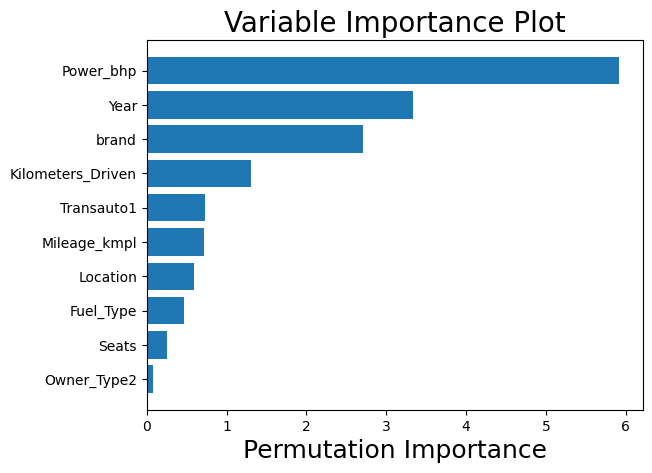

In [92]:
plt.barh(index, tips_sum_by_day)
plt.title('Variable Importance Plot', fontsize=20)
plt.xlabel('Permutation Importance', fontsize=18)
plt.ylabel('', fontsize=18)
plt.show()

In [37]:
model.feature_names_
model.feature_importances_
import matplotlib.pyplot as plt
model.feature_importances_
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()
import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(bst)
plt.show()

AttributeError: 'Booster' object has no attribute 'feature_importances_'